In [2]:
% matplotlib inline

import importlib
import pickle
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import randint as sp_randint

import imblearn.over_sampling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report,
                             roc_curve, roc_auc_score, log_loss)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier

import airbnb
importlib.reload(airbnb)

seaborn.set_context(context='poster')
FIGSIZE = (10,7)

In [3]:
training_set, validation_set, holdout_set, agb, sessions = airbnb.main()

INFO:root: Begin extract
INFO:root: Begin transform
/Users/timcodes/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
INFO:root: Train Validation Holdout Split
INFO:root: Return: 


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0 to DejaVu Sans ('/Users/timcodes/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=17.6 to DejaVu Sans ('/Users/timcodes/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=19.200000000000003 to DejaVu Sans ('/Users/timcodes/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


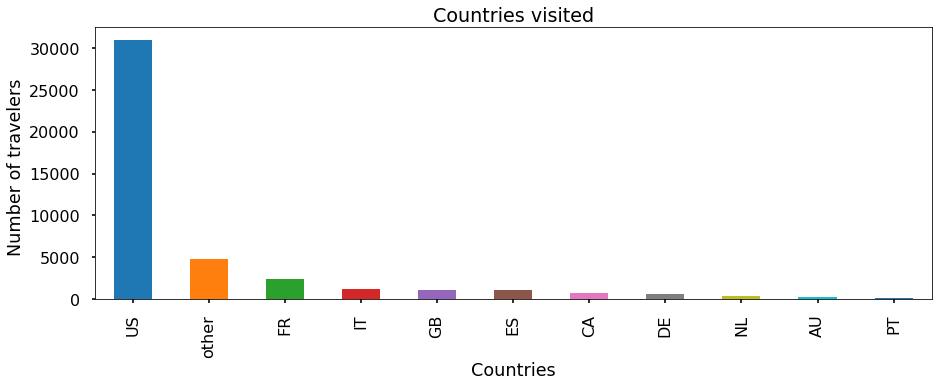

In [4]:
plt.figure(figsize=[15,5])
training_set['country_destination'].value_counts().plot(kind='bar')
plt.ylabel('Number of travelers ')
plt.xlabel('Countries')
plt.title('Countries visited');

## Schema for testing:
Basic elements:
- **Pipe Transforms**: `X, y = pipe_transform(_data-_ set)` to get `X`, `y` for `train`, `val`, `holdout` sets. The pipe transform downselects target and features.
- **SMOTE**: `x_train_smote`, `y_train_smote` for `training set` only.
- **Classifier Dictionary**: Generic store for classifier objects, to be used for various **pipe transforms** Create a dictionary with the following fields
    - clf: `LogisticRegression`, `RandomForest`, `GradientBoostedTree`, `XGBoost`, `SVC`
    - param_distributions=param_dist,
    - n_iter=n_iter_search, 
    - scoring=scoring, 
    - refit='AUC'
- **Model Dictionary**: this dictionary contains, for each successul/relevant trained model:
    - 


## Define pipeline-transform functions:

In [15]:
def pipe_france_vs_usa(df):
    """ Accepts test_users training or validation or test df and provides the pipeline 
    """
    df = df[(df['country_destination']=='US')|(df['country_destination']=='FR')]
    y = airbnb.binarize_y(df['country_destination'], binary_country='FR')
    X = df.drop('country_destination', axis=1)
    X = airbnb.get_df_with_dummies(X)
    
    return X, y


def pipe_france_vs_gb(df):
    """ Accepts test_users training or validation or test df and provides the pipeline 
    """
    df = df[(df['country_destination']=='GB')|(df['country_destination']=='FR')]
    y = airbnb.binarize_y(df['country_destination'], binary_country='FR')
    X = df.drop('country_destination', axis=1)
    X = airbnb.get_df_with_dummies(X)
    
    return X, y


def pipe_usa_vs_not(df):
    """ Accepts test_users training or validation or test df and provides the pipeline for the binary 
    """
    y = airbnb.binarize_y(df['country_destination'], binary_country='US')
    X = df.drop('country_destination', axis=1)
    X = airbnb.get_df_with_dummies(X)
    
    return X, y


def pipe_multiclass(df):
    """ Accepts test_users training or validation or test df and provides the pipeline 
    """
    # df = df[(df['country_destination']=='US')|(df['country_destination']=='FR')]
    # y = airbnb.binarize_y(df['country_destination'], binary_country='US')
    le =  LabelEncoder()
    y = le.fit_transform(df['country_destination'])
    X = df.drop('country_destination', axis=1)
    X = airbnb.get_df_with_dummies(X)
    
    return X, y


pipe_dict = {'fr_usa': pipe_france_vs_usa,
             'usa_not': pipe_usa_vs_not,
             'multiclass':pipe_multiclass,
            }


# PLOTTING:
def make_ROC(estimator, X_train, y_train, X_val):
    y_score = estimator.fit(X_train, y_train).predict_proba(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_score[:,1])
    
    plt.figure(figsize=FIGSIZE)
    plt.plot(fpr, tpr)
    plt.plot(fpr, fpr, 'r--')
    plt.title('ROC AUC = {:1.3}'.format(roc_auc_score(y_val, y_score[:,1])))
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate');

In [6]:
smote = imblearn.over_sampling.SMOTE(ratio='auto', random_state = 42)
model_dict = {}

for key, fun in pipe_dict.items():
    print('\n')
    print('Model = ', key)
    
    # train and validation set transformations:
    print('Pipe Transform:')
    X_val, y_val = fun(validation_set)
    X_train, y_train = fun(training_set)
    X_tr_smote, y_tr_smote = smote.fit_sample(X_train, y_train) 
    
    print('Logistic Regression, Multiclass, with Randomized Search and CV ...')
    lrm = OneVsRestClassifier(LogisticRegression())

    parameter_distributions = {'C': np.logspace(-3,3),
                              'penalty': ['l1', 'l2']}

    random_logit_mult = RandomizedSearchCV(lrm, 
                                           param_distributions={'estimator__C': np.logspace(-3,3), 
                                                                'estimator__penalty': ['l1', 'l2']},
                                           n_iter=10, 
                                           scoring={'Log Loss':'neg_log_loss'}, 
                                           refit='Log Loss')

    random_logit_mult.fit(X_tr_smote, y_tr_smote)                      
    y_pred = random_logit_mult.predict_proba(X_val)
    LR_log_loss = log_loss(y_val, y_pred)
    print('-'*79)
    print('Best Logistic Regression Log Loss (' + key + ') = ', LR_log_loss)
    

    print('Random Forest with Randomized Search and CV ...')
    randomc_rfc = RandomizedSearchCV(RandomForestClassifier(), 
                                     param_distributions={"n_estimators": [9, 20, 50],
                                                          "max_depth": [3, None],
                                                          "max_features": sp_randint(1, 11),
                                                          "min_samples_split": sp_randint(2, 11),
                                                          "min_samples_leaf": sp_randint(1, 11),
                                                          "bootstrap": [True, False],
                                                          "criterion": ["gini", "entropy"]},
                                     n_iter=10, 
                                     scoring={'Log Loss':'neg_log_loss'}, 
                                     refit='Log Loss',
                                     )

    randomc_rfc.fit(X_tr_smote, y_tr_smote)                      
    y_pred = randomc_rfc.predict_proba(X_val)
    RF_log_loss = log_loss(y_val, y_pred)
    print('-'*79)
    print('Best Random Forest Log Loss (' + key + ') = ', RF_log_loss)



Model =  fr_usa
Pipe Transform:
Logistic Regression, Multiclass, with Randomized Search and CV ...
-------------------------------------------------------------------------------
Best Logistic Regression Log Loss (fr_usa) =  0.6791296022570559
Random Forest with Randomized Search and CV ...
-------------------------------------------------------------------------------
Best Random Forest Log Loss (fr_usa) =  0.653110748796079


Model =  usa_not
Pipe Transform:
Logistic Regression, Multiclass, with Randomized Search and CV ...
-------------------------------------------------------------------------------
Best Logistic Regression Log Loss (usa_not) =  0.692130601060683
Random Forest with Randomized Search and CV ...
-------------------------------------------------------------------------------
Best Random Forest Log Loss (usa_not) =  0.6885879291422097


Model =  multiclass
Pipe Transform:
Logistic Regression, Multiclass, with Randomized Search and CV ...


/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


-------------------------------------------------------------------------------
Best Logistic Regression Log Loss (multiclass) =  2.4076438644849576
Random Forest with Randomized Search and CV ...
-------------------------------------------------------------------------------
Best Random Forest Log Loss (multiclass) =  1.5409281649950899


In [9]:
y_pred = randomc_rfc.predict(X_val)
cl_report = classification_report(y_val, y_pred)
print(cl_report)

             precision    recall  f1-score   support

          0       0.03      0.01      0.02        87
          1       0.02      0.01      0.01       162
          2       0.02      0.01      0.01       131
          3       0.04      0.02      0.02       279
          4       0.09      0.04      0.05       584
          5       0.04      0.01      0.02       313
          6       0.02      0.01      0.01       344
          7       0.00      0.00      0.00       104
          8       0.00      0.00      0.00        28
          9       0.71      0.90      0.79      7661
         10       0.12      0.04      0.06      1209

avg / total       0.52      0.64      0.57     10902

